In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from datasetcontroller.datacontroller import DataController

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# import tensorflow as tf
import time
import numpy as np

2023-06-08 09:36:13.938097: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-08 09:36:13.976861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 데이터셋 폴더 경로 설정
path = os.path.join("/workspace")
data_path = os.path.join(path,'cmaqProjectdata')

# 모델 체크포인트
proj_path = os.path.join(path,'repos','cmaqProject')
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_pixlasso_v1_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# 컨트롤러
datacontroller = DataController(data_path = data_path)

# 기본 control matrix, smoke, cmaq 데이터셋 
control_matrix, _, target_arr = datacontroller.get_yearly_dataset()
X_train, X_test, y_train, y_test = train_test_split(control_matrix, target_arr, test_size=0.2, random_state=42 )

#
ctp_names_info = {}
ctp_gpd = datacontroller.get_ctp()
for i in range(len(ctp_gpd)):
    tm = ctp_gpd.loc[i,['CTP_ENG_NM','CTP_KOR_NM']].values
    ctp_names_info[tm[1]] = tm[0]
ctp_names_info['전국'] = 'korea'
ctp_names_info

/usr/local/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/datasetcontroller/datacontroller.py:55: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


{'서울특별시': 'Seoul',
 '부산광역시': 'Busan',
 '대구광역시': 'Daegu',
 '인천광역시': 'Incheon',
 '광주광역시': 'Gwangju',
 '대전광역시': 'Daejeon',
 '울산광역시': 'Ulsan',
 '세종특별자치시': 'Sejong-si',
 '경기도': 'Gyeonggi-do',
 '강원도': 'Gangwon-do',
 '충청북도': 'Chungcheongbuk-do',
 '충청남도': 'Chungcheongnam-do',
 '전라북도': 'Jeollabuk-do',
 '전라남도': 'Jellanam-do',
 '경상북도': 'Gyeongsangbuk-do',
 '경상남도': 'Gyeongsangnam-do',
 '제주특별자치도': 'Jeju-do',
 '전국': 'korea'}

## 기본 텐서플로 알고리즘

In [10]:
from nnmodules.pixbylasso import LassomodPix_v2
import tensorflow as tf

In [11]:
pixlasso = LassomodPix_v2(data_path)
pixlasso.compile()

# 불러오기
checkpoint = tf.train.Checkpoint(
                                 pixlasso=pixlasso,
                                 )

####### 모델 체크포인트 ##########
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=12)
checkpoint.restore(manager.latest_checkpoint)

/usr/local/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


67 82


/usr/local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/workspace/repos/cmaqProject/experiment/nnmodules/pixbylasso.py:44: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:5179 +type=crs
Right CRS: EPSG:5179

  joined = gpd.sjoin(ctp_rvn_gpd, grid_data.to_crs(5179), op='contains')


CPU times: user 21.3 s, sys: 797 ms, total: 22.1 s
Wall time: 19.3 s


<Axes: >

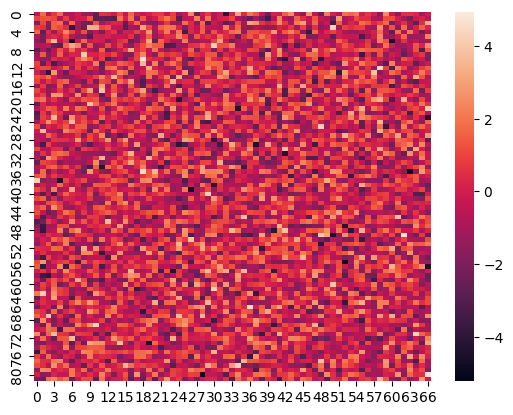

In [12]:
%%time
pred = pixlasso(X_train)
sns.heatmap(pred[0,:,:,0][::-1])

In [13]:
%%time
def train_step_fine(pix_index, input,target, x, y, optimizer):
    with tf.GradientTape() as tape:
        output = pixlasso.grid_layers[pix_index](input)
        sub_target = target[:,x,y,:]
        l1_loss = pixlasso.lose_mse(sub_target, output)
    
    gradients = tape.gradient(l1_loss, pixlasso.grid_layers[pix_index].trainable_variables)
    optimizer.apply_gradients(zip(gradients, pixlasso.grid_layers[pix_index].trainable_variables))
    return l1_loss

epochs = 3000
early_stop_n = 20
down_lr_epoch = 500
down_lr_ratio = 0.1

for i, pix_index in enumerate(pixlasso._indexed_grid_point.index.tolist()):
# for i, pix_index in enumerate(pixlasso._indexed_grid_point.loc[pixlasso._indexed_grid_point.CTP_KOR_NM == '경기도'].index.tolist()):
    lr = 0.001
    optimizer = tf.keras.optimizers.Adam(lr)
    stop_count = 0
    x, y = pix_index%82,pix_index//82

    #저장
    if (i + 1) % 500 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    start_time = time.time()
    for epoch in range(epochs):

        # reset lr for fine tune
        if epoch != 0 and epoch % down_lr_epoch == 0:
            lr = lr * down_lr_ratio
            optimizer = tf.keras.optimizers.Adam(lr)


        l1_loss = train_step_fine(pix_index, X_train,y_train, x, y, optimizer)

        # set early stop
        if epoch != 0 and l1_loss_before <= l1_loss:
            stop_count += 1
            
        if stop_count == early_stop_n:
            print(f"\rGrid {pix_index} Epoch {epoch}/ loss: {l1_loss:.4f} / time: {time.time() - start_time:.2f} sec / early_stoped", end="")
            break

        l1_loss_before = l1_loss
        print(f"\rGrid {pix_index} Epoch {epoch}/ loss: {l1_loss:.4f} / time: {time.time() - start_time:.2f} sec", end="")
    print()

Grid 0 Epoch 2552/ loss: 0.0854 / time: 16.82 sec / early_stoped
Grid 1 Epoch 2564/ loss: 0.0688 / time: 16.69 sec / early_stoped
Grid 2 Epoch 2546/ loss: 0.0775 / time: 16.48 sec / early_stoped
Grid 3 Epoch 2552/ loss: 0.0661 / time: 16.88 sec / early_stoped
Grid 4 Epoch 2554/ loss: 0.1073 / time: 16.65 sec / early_stoped
Grid 5 Epoch 2552/ loss: 0.0890 / time: 16.73 sec / early_stoped
Grid 6 Epoch 2558/ loss: 0.1184 / time: 17.07 sec / early_stoped
Grid 7 Epoch 2558/ loss: 0.1140 / time: 16.96 sec / early_stoped
Grid 8 Epoch 2552/ loss: 0.0648 / time: 16.51 sec / early_stoped
Grid 9 Epoch 2560/ loss: 0.1087 / time: 16.69 sec / early_stoped
Grid 10 Epoch 2554/ loss: 0.0953 / time: 16.75 sec / early_stoped
Grid 11 Epoch 2549/ loss: 0.0890 / time: 16.60 sec / early_stoped
Grid 12 Epoch 2559/ loss: 0.0983 / time: 16.58 sec / early_stoped
Grid 13 Epoch 2568/ loss: 0.1244 / time: 16.92 sec / early_stoped
Grid 14 Epoch 2559/ loss: 0.1131 / time: 16.77 sec / early_stoped
Grid 15 Epoch 2549/ 

<Axes: >

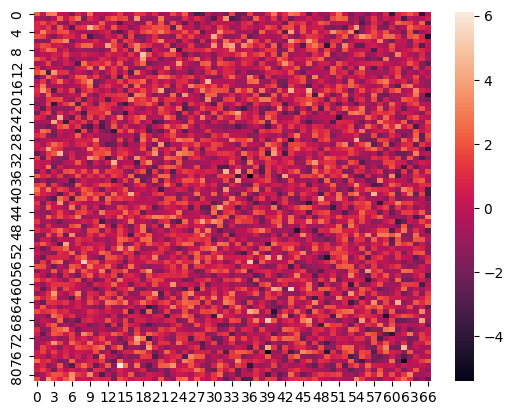

In [ ]:
pred2 = pixlasso(X_train)
sns.heatmap(pred2[0,:,:,0][::-1])

In [ ]:
%%time
pred_train = pixlasso(X_train)
pred_test = pixlasso(X_test)

CPU times: user 6.32 s, sys: 146 ms, total: 6.47 s
Wall time: 5.1 s


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse_train = mean_squared_error(pred_train.reshape(-1), y_train.reshape(-1))
rmse_train = mse_train**0.5
r2_train = r2_score(pred_train.reshape(-1), y_train.reshape(-1))

mse_test = mean_squared_error(pred_test.reshape(-1), y_test.reshape(-1))
rmse_test = mse_test**0.5
r2_test = r2_score(pred_test.reshape(-1), y_test.reshape(-1))

print(f'trainset / mse: {mse_train} / rmse: {rmse_train} / r2: {r2_train}')
print(f'testset / mse: {mse_test} / rmse: {rmse_test} / r2: {r2_test}')

Text(0, 0.5, 'Normalized Mean Error (NME %)')

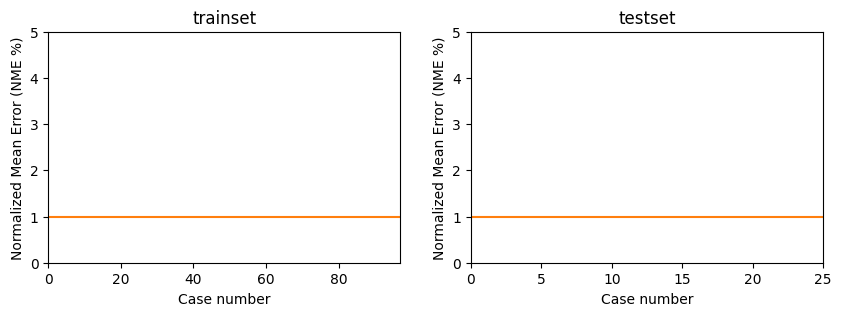

In [ ]:
# In[]
def NME(y_true, y_pred):
    return np.sum( abs( (y_pred - y_true) / y_true ) ) / len(y_pred)

result_test = []                                                                                                                                                                                                                                                                                                      
for i in range(len(X_test)):
    result_test.append(NME(pred_test[i][::-1].numpy().reshape(-1), y_test[i][::-1].reshape(-1)))

result_train = []                                                                                                                                                                                                                                                                                                              
for i in range(len(X_train)):
    result_train.append(NME(pred_train[i][::-1].numpy().reshape(-1), y_train[i][::-1].reshape(-1)))

#
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title('trainset')
plt.plot(np.arange(1,len(X_train)+1,1), np.array(result_train) * 100)
plt.xlim([0,len(X_train)+1])
plt.ylim([0,5])
plt.plot([0,len(X_train)+1],[1,1])
plt.xlabel('Case number') ; plt.ylabel('Normalized Mean Error (NME %)')

plt.subplot(1,2,2)
plt.title('testset')
plt.plot(np.arange(1,len(X_test)+1,1), np.array(result_test) * 100)
plt.xlim([0,len(X_test)+1])
plt.ylim([0,5])
plt.plot([0,len(X_test)+1],[1,1])
plt.xlabel('Case number') ; plt.ylabel('Normalized Mean Error (NME %)')

Text(0, 0.5, 'target')

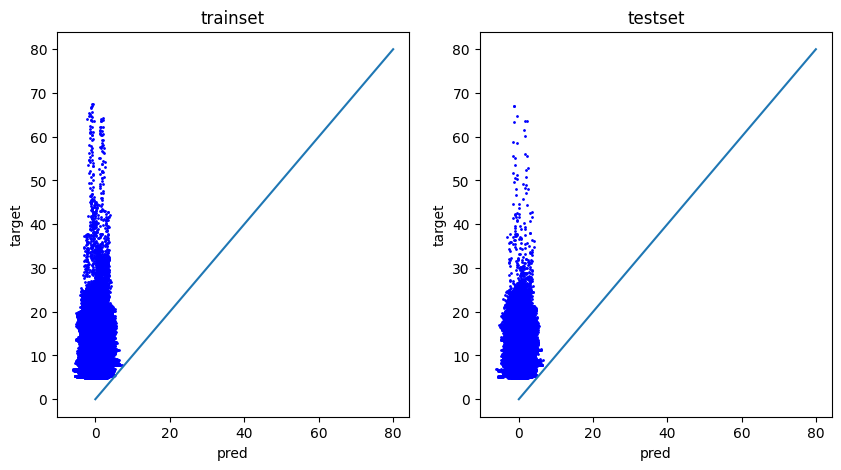

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('trainset')
plt.plot(pred_train.numpy().reshape(-1), y_train.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')

plt.subplot(1,2,2)
plt.title('testset')
plt.plot(pred_test.numpy().reshape(-1), y_test.reshape(-1),'bo', markersize=1)
plt.plot([0,80],[0,80])
plt.xlabel('pred') ; plt.ylabel('target')